# This code generate scatter and density plot from coordinates of neurons generated in the cell_count code

### Load packages and Change the working directory 

In [215]:
import pandas as pd
import numpy as np
import os
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.feature import canny
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.style.use("gadfly")
plt.interactive(True)

# Set directory
os.chdir("/Users/jun/Documents/Work/Project/Licking/Brainrender&cell_count/")

### Read files and manipulate coordinates for plotting in Allen CCF

In [216]:
# read files
phox2b8 = pd.read_csv("/Users/jun/Documents/Work/Project/Licking/Brainrender&cell_count/cell_count_phox2b#8/table.txt")
phox2b9 = pd.read_csv("/Users/jun/Documents/Work/Project/Licking/Brainrender&cell_count/cell_count_phox2b#9/table.txt")
phox2b18 = pd.read_csv("/Users/jun/Documents/Work/Project/Licking/Brainrender&cell_count/cell_count_phox2b#18/table.txt")
phox2b19 = pd.read_csv("/Users/jun/Documents/Work/Project/Licking/Brainrender&cell_count/cell_count_phox2b#19/table.txt")

# file_name = [phox2b8, phox2b9, phox2b18, phox2b19]
file_name = [phox2b8, phox2b9, phox2b18, phox2b19]

## The follwoing sections convert Paxinos coordinates into Allen CCF coordinates.
In Allen CCF coordinate system, the Bregma coordinate is AP: 5400, ML: 5700, DV: 0. (AP: 540, ML 570, DV 0. Somehow after extracting the brain outline they are AP: 540, ML: 570, ML: 0).  

In [217]:
# Multiply by 100. Coordinates posterior to the Bregma will become +. Coordinates anterior to the Bregma will become -. 
for df in file_name:
    df['AP_location'] *= -100.0
    df['DV_location'] *= 100.0
    df['ML_location'] *= 100.0

In [218]:
# Convert AP coordinates
# Add 540 to convert in Allen CCF coordinates. For example, The tip of the brain in Paxinos is ~ +5.4. This is converted into -540 in the code block above.
# After adding 540, it will be 0 , which is the tip of the brain Allen CCF coordinate. 

for df in file_name:
    df['AP_location'] = df['AP_location'] + 540

In [219]:
# Convert ML coordinates. Same as the code block above. Add 570 to the coordinates.
for df in file_name:
    df['ML_location'] = df['ML_location'] + 570

In [220]:
# merge the data from same injection scheme.
IRt = pd.concat([phox2b8, phox2b9])
PCRt = pd.concat([phox2b18, phox2b19])

file_name = [IRt, PCRt]

### Generate brain outlines

In [221]:
# find rostral and caudal ends.
# The coronal outlines in between rostral_end to caudal_end will be generated in the next block.
# They can be manually defined if needed.   
nucleus = "PARN"

rostral = []
caudal = []
for df in file_name:
    ma = df['AP_location'].max()
    mi = df['AP_location'].min()
    caudal.append(ma)
    rostral.append(mi)

rostral_end = int(np.floor(max(rostral)))
caudal_end = int(np.floor(min(caudal)))

In [50]:
# brain outlines
# coronal

atlas = np.load("/Users/jun/Documents/MATLAB/Allen/annotation_volume_10um_by_index.npy")

# coronal outline
NumberOfMerge = int(np.floor(caudal_end - rostral_end))

AP,DV,ML = atlas.shape
coronal = np.empty((DV, ML, NumberOfMerge), dtype=np.float16)
for i in range(NumberOfMerge):
    coronal[:,:,i] = canny(np.where(atlas[int(np.floor(rostral_end)) + i,:,:] <= 1, 0, 1), sigma=1.5, low_threshold=0.2, high_threshold=0.8)

coronal_merge = np.sum(coronal, axis=2)
coronal_merge = coronal_merge[:,:,np.newaxis].astype(np.float64)

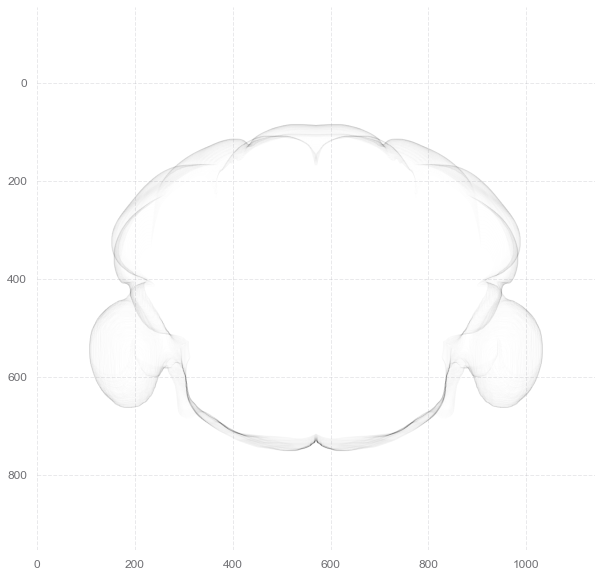

In [55]:
# test visualization coronal
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(coronal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")
plt.show()

In [64]:
# horizontal outline
NumberOfMerge = 100 # arbitrary value.
AP, DV, ML = atlas.shape
horizontal = np.empty((AP, ML, NumberOfMerge), dtype=np.float16)

for i in range(NumberOfMerge):
    horizontal[:,:,i] = canny(np.where(atlas[:,550 + i,:] <= 1, 0, 1), sigma=1.5, low_threshold=0.2, high_threshold=0.8)
# 550 is arbitrary value to specify where to start merging. 0 means merging 100 sections from the top surface of the brain.

horizontal_merge = np.sum(horizontal, axis=2)
horizontal_merge = horizontal_merge[:,:,np.newaxis].astype(np.float64)
# horizontal_merge = horizontal_merge[840:1320,:,:] # crop in arbitrary AP range

(-0.5, 1139.5, 1319.5, -0.5)

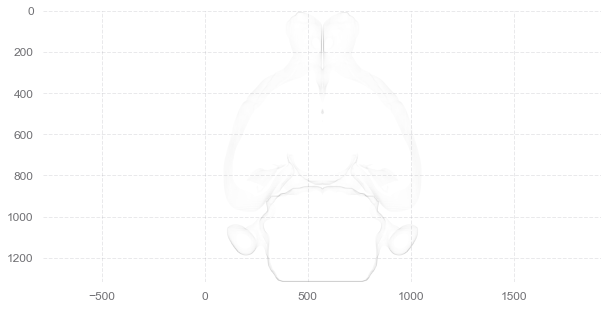

In [65]:
# test visualization horizontal

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(horizontal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")
#ax.set_ylim(780, 300)

In [66]:
# sagittal outline
# Set parameters
import numpy as np
from skimage.feature import canny
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import rot90

# Load data
NumberOfMerge = 100 # arbitrary value
AP, DV, ML = atlas.shape
sagittal = np.empty((AP, DV, NumberOfMerge), dtype=np.float16)

for i in range(NumberOfMerge):
    sagittal[:,:,i] = canny(np.where(atlas[:,:,570+i] <= 1, 0, 1), sigma=1.5, low_threshold=0.2, high_threshold=0.8)
    # atlas[:, x + i, :] x = arbitrary value. find a value that gives a good outline

sagittal_merge = np.sum(sagittal, axis=2)
sagittal_merge = sagittal_merge.astype(np.float64)
sagittal_merge = rot90(sagittal_merge, k=3) # crop in arbitrary AP range
sagittal_merge = sagittal_merge[:,::-1]

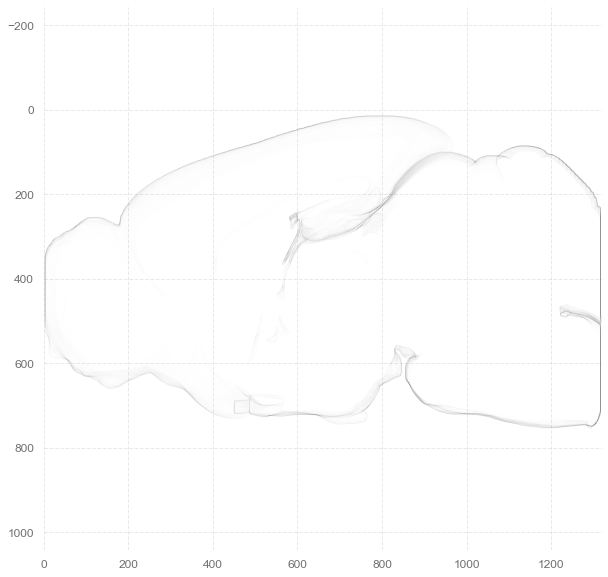

In [67]:
# test visualization sagittal
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sagittal_merge, cmap="binary", zorder=0)
plt.axis("equal")
plt.show()

### Plot coronal sections

In [222]:
# Color scheme
c = ["#FF62A4", "#00BCFD", "#D3C93A"]
cmap = ["PuRd", "Blues", "Wistia"]

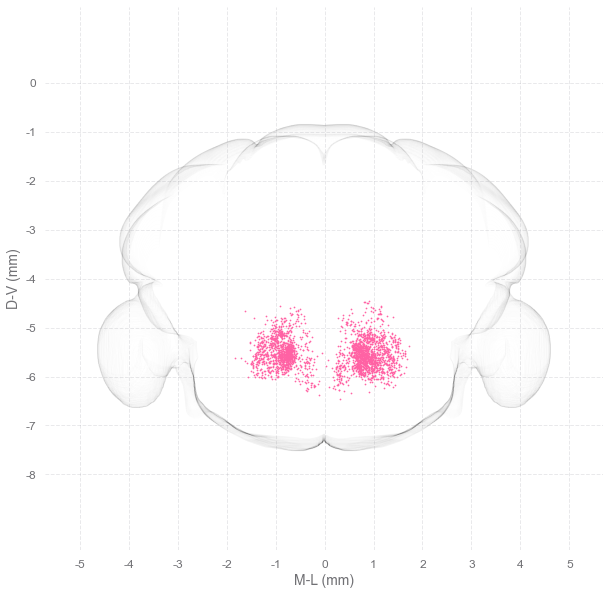

In [80]:
# Scatter plot coronal - single. This can be done in Brainrender.
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(coronal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")

# Plot neurons
ax.scatter(file_name[i].ML_location, file_name[i].DV_location, c = c[i],  s =0.5, zorder = 1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['0', '-1', '-2', '-3', '-4','-5','-6','-7','-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Coronal_Scatter_"
sample = "PCRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

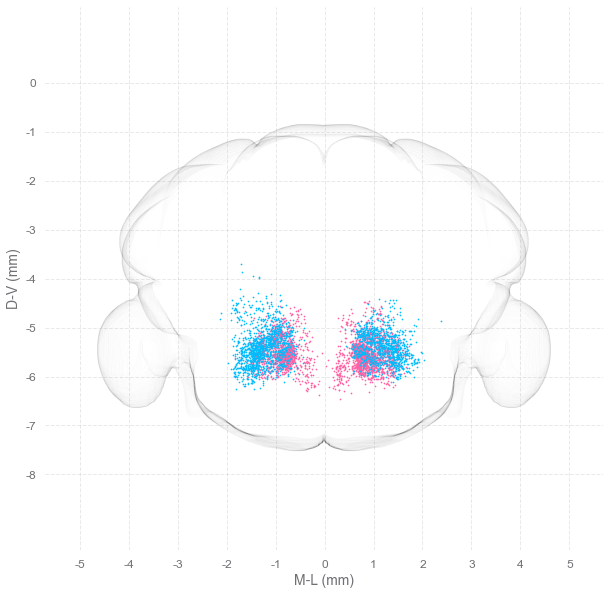

In [82]:
# Scatter plot coronal - merge. This can be done in Brainrender.

i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(coronal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")

# Plot neurons
#Iterate over each DataFrame in file_name
for i in range(len(file_name)):
    ax.scatter(file_name[i].ML_location, file_name[i].DV_location, c=c[i], s=0.5, zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['0', '-1', '-2', '-3', '-4','-5','-6','-7','-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Coronal_Scatter_Merge"
sample = ""
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

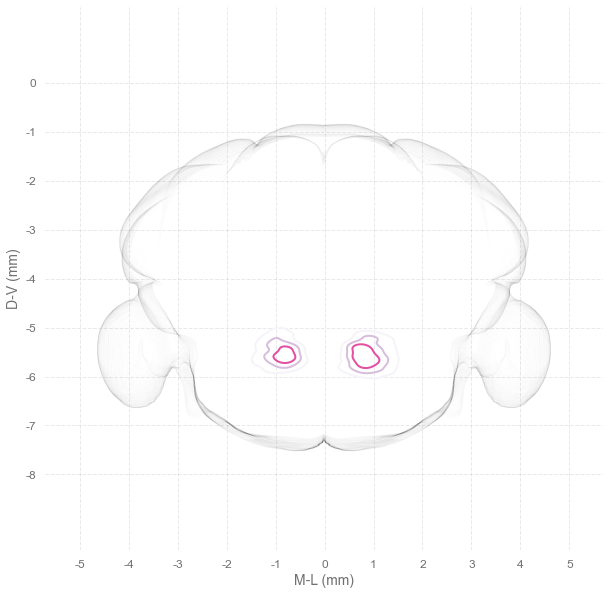

In [223]:
# Density plot coronal - single.
i = 0 #change this to plot a desired group

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(coronal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")

# Plot density
ax = sns.kdeplot(x=file_name[i].ML_location, y=file_name[i].DV_location, 
                 cmap=cmap[i], n_levels=4, bw_method=0.2, linewidths=2, thresh=0.25, zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['0', '-1', '-2', '-3', '-4','-5','-6','-7','-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Coronal_Density_"
sample = "PCRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

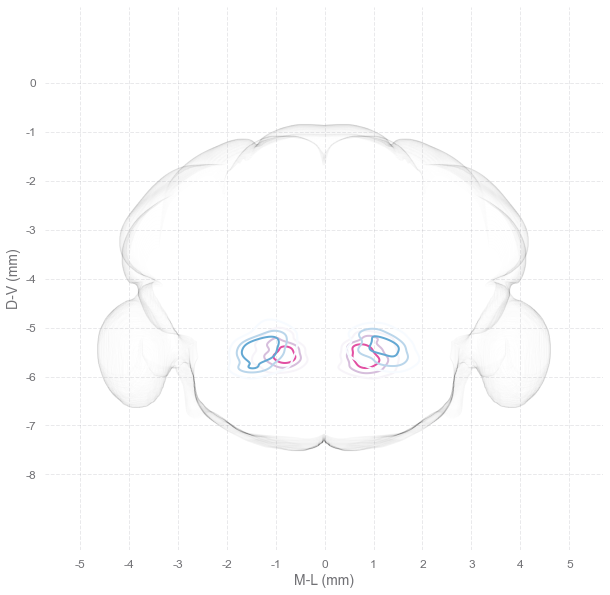

In [84]:
# Density plot coronal - merge.
i = 0 #change this to plot a desired group

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(coronal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")

# Plot density
#Iterate over each DataFrame in file_name
for i in range(len(file_name)):
    ax = sns.kdeplot(x=file_name[i].ML_location, y=file_name[i].DV_location, 
                 cmap=cmap[i], n_levels=4, bw_method=0.2, linewidths=2, thresh=0.25, zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['0', '-1', '-2', '-3', '-4','-5','-6','-7','-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Coronal_Density_Merge"
sample = ""
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

### Plot horizontal sections

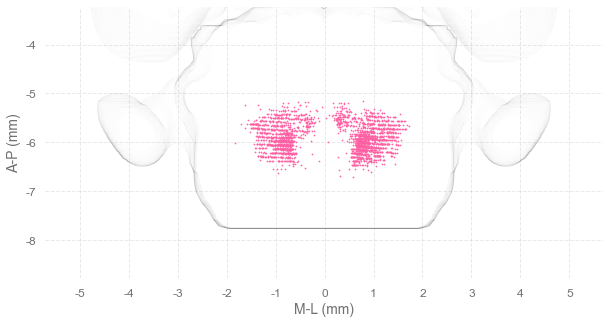

In [92]:
# Scatter plot horizontal - single. This can be done in Brainrender.

c = ["#FF62A4", "#00BCFD", "#D3C93A"]
cmap = ["PuRd", "Blues", "Wistia"]

i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(horizontal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")
ax.set_ylim(1340, 940) # -4mm to -8mm

# Plot neurons
ax.scatter(file_name[i].ML_location, file_name[i].AP_location, c = c[i],  s =0.5, zorder = 1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([940, 1040, 1140, 1240, 1340])
ax.set_yticklabels(['-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('A-P (mm)')

# change the file name when you save
group = "Horizontal_Scatter_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext 
plt.savefig(save_name, dpi=1200, format="pdf")

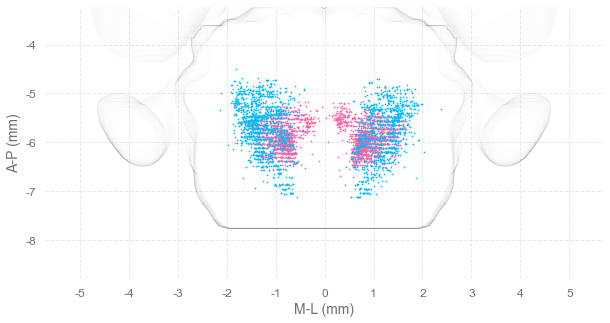

In [96]:
# Scatter plot horizontal - merge. This can be done in Brainrender.
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(horizontal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")
ax.set_ylim(1340, 940) # -4mm to -8mm

# Plot neurons
#Iterate over each DataFrame in file_name
for i in range(len(file_name)):
    ax.scatter(file_name[i].ML_location, file_name[i].AP_location, c = c[i],  s =0.5, zorder = 1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([940, 1040, 1140, 1240, 1340])
ax.set_yticklabels(['-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('A-P (mm)')

# change the file name when you save 
group = "Horizontal_Scatter_Merge"
sample = ""
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

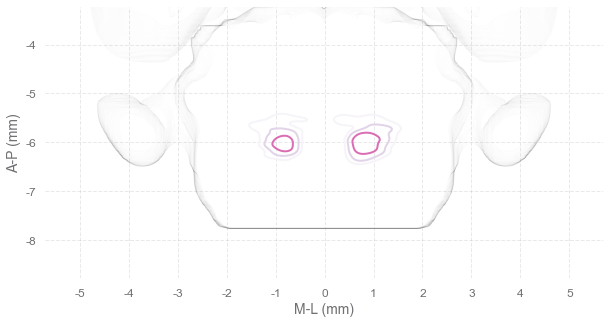

In [97]:
# Density plot horizontal - single.
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(horizontal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")
ax.set_ylim(1340, 940) # -4mm to -8mm

# Plot density
ax = sns.kdeplot(x=file_name[i].ML_location, y=file_name[i].AP_location, 
                 cmap=cmap[i], n_levels=4, bw_method=0.2, linewidths=2, thresh=0.25, zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([940, 1040, 1140, 1240, 1340])
ax.set_yticklabels(['-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('A-P (mm)')

# change the file name when you save 
group = "Horizontal_Density_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  **contour_kws,
/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  **contour_kws,
/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  **contour_kws,


IndexError: list index out of range

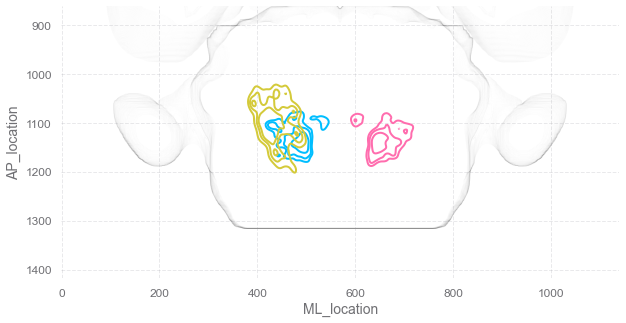

In [231]:
# Density plot horizontal - Merge.
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(horizontal_merge[:, :, 0], cmap="binary", zorder=0)
plt.axis("equal")
ax.set_ylim(1340, 940) # -4mm to -8mm

# Plot density
#Iterate over each DataFrame in file_name
for i in range(len(file_name)):
    ax = sns.kdeplot(x=file_name[i].ML_location, y=file_name[i].AP_location, 
                 cmap=cmap[i], n_levels=4, bw_method=0.2, linewidths=2, thresh=0.25, zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([70, 170, 270, 370, 470, 570, 670, 770, 870, 970, 1070])
ax.set_xticklabels(['-5', '-4', '-3', '-2', '-1','0','1','2','3','4','5'])

ax.set_yticks([940, 1040, 1140, 1240, 1340])
ax.set_yticklabels(['-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('M-L (mm)')
plt.ylabel('A-P (mm)')

# change the file name when you save 
group = "Horizontal_Density_Merge"
sample = ""
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

## Plot sagittal section

In [225]:
# If you want to plot left and right side separately use this block
# If left and right sides are plotted together skip this block. This is low tech but should work well.

IRt_left = IRt[IRt.ML_location <= 570]
IRt_right = IRt[IRt.ML_location >= 570]

PCRt_left= PCRt[PCRt.ML_location <=570]
PCRt_right = PCRt[PCRt.ML_location >=570]

file_name = [IRt_left, PCRt_left, IRt_right, PCRt_right]

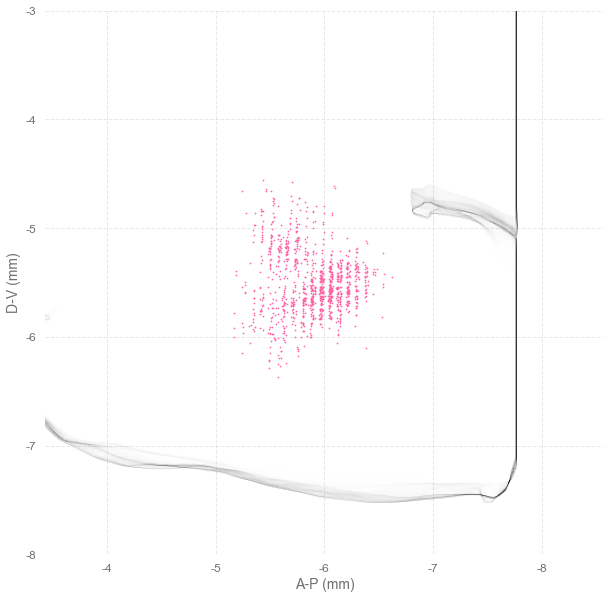

In [226]:
# Scatter plot sagittal - single. This can be done in Brainrender.
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sagittal_merge, cmap="binary", zorder=0)
plt.axis("equal")
ax.set_xlim(940, 1340) # -4mm to -8mm
ax.set_ylim(800, 300) # -3mm to -8mm

# Plot neurons
ax.scatter(file_name[i].AP_location, file_name[i].DV_location, c = c[i],  s =0.5, zorder = 1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([940, 1040, 1140, 1240, 1340])
ax.set_xticklabels(['-4', '-5', '-6', '-7', '-8'])

ax.set_yticks([300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['-3', '-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('A-P (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Sagittal_Scatter_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

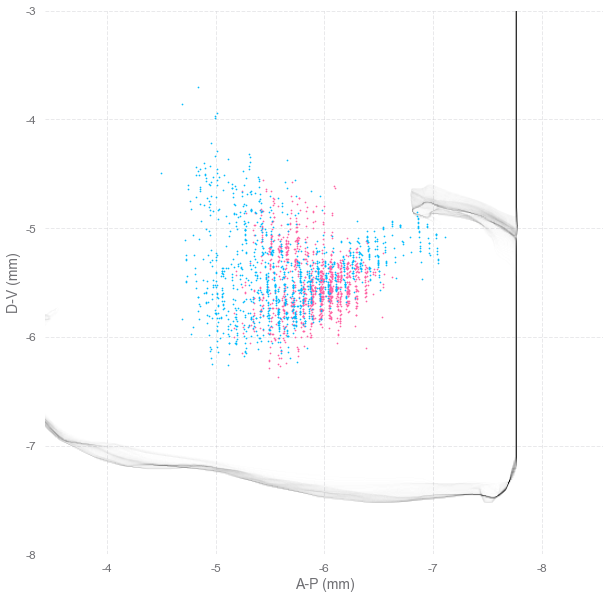

In [227]:
# Scatter plot sagittal - merge. This can be done in Brainrender.
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sagittal_merge, cmap="binary", zorder=0)
plt.axis("equal")
ax.set_xlim(940, 1340) # -4mm to -8mm
ax.set_ylim(800, 300) # -3mm to -8mm

# Plot neurons
# Iterate over each DataFrame in file_name
# To run first two dataframe range(0,2), for third and fourth range(2,4)
i_range = range(0, 2)  # set the desired range of i values
j_range = range(len(i_range))  # set the desired range of j values based on the length of i_range
for i, j in zip(i_range, j_range):
    ax.scatter(file_name[i].AP_location, file_name[i].DV_location, c = c[j],  s =0.5, zorder = 1)


# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([940, 1040, 1140, 1240, 1340])
ax.set_xticklabels(['-4', '-5', '-6', '-7', '-8'])

ax.set_yticks([300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['-3', '-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('A-P (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Sagittal_Scatter_Merge_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


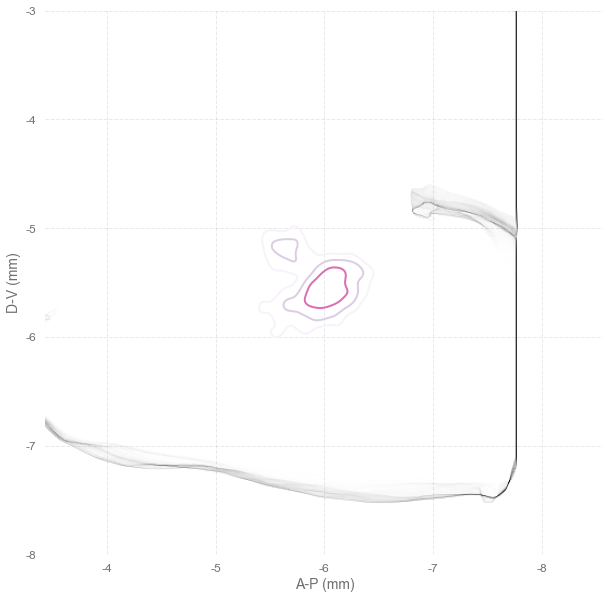

In [257]:
# Density plot sagittal - single. 
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sagittal_merge, cmap="binary", zorder=0)
plt.axis("equal")
ax.set_xlim(940, 1340) # -4mm to -8mm
ax.set_ylim(800, 300) # -3mm to -8mm

# Plot neurons
ax = sns.kdeplot(file_name[i].AP_location, file_name[i].DV_location, cmap = cmap[i], 
                 n_levels=4, bw_method=0.2, linewidths=2, thresh=0.25, zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([940, 1040, 1140, 1240, 1340])
ax.set_xticklabels(['-4', '-5', '-6', '-7', '-8'])

ax.set_yticks([300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['-3', '-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('A-P (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Sagittal_Density_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


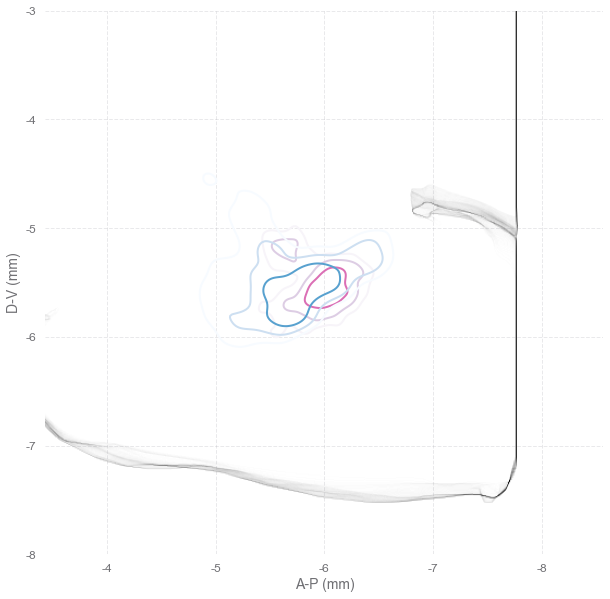

In [258]:
# Density plot sagittal - single. 
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sagittal_merge, cmap="binary", zorder=0)
plt.axis("equal")
ax.set_xlim(940, 1340) # -4mm to -8mm
ax.set_ylim(800, 300) # -3mm to -8mm

# Plot neurons
i_range = range(0, 2)  # set the desired range of i values
j_range = range(len(i_range))  # set the desired range of j values based on the length of i_range
for i, j in zip(i_range, j_range):
    ax = sns.kdeplot(file_name[i].AP_location, file_name[i].DV_location, cmap = cmap[j], 
                 n_levels=4, bw_method=0.2, linewidths=2, thresh=0.25, zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([940, 1040, 1140, 1240, 1340])
ax.set_xticklabels(['-4', '-5', '-6', '-7', '-8'])

ax.set_yticks([300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['-3', '-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('A-P (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Sagittal_Density_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

### Diferent plotting style for density plot. This might look better.  

/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jun/Documents/Codes/miniforge3_Rosetta/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  **contour_kws,


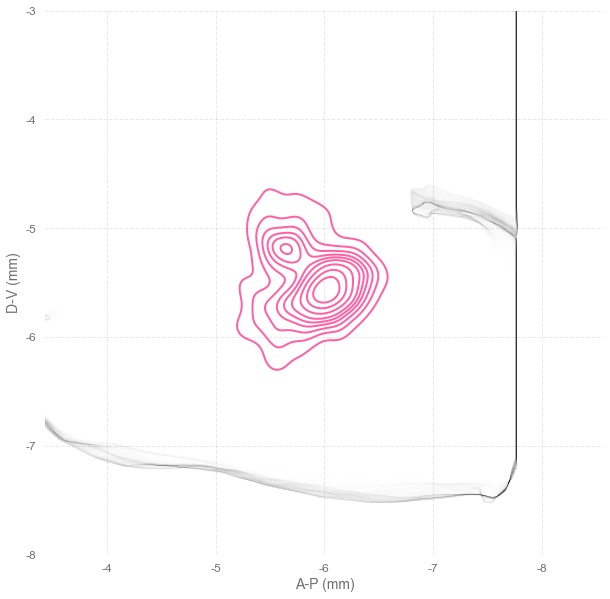

In [248]:
# Density plot sagittal - single. 
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sagittal_merge, cmap="binary", zorder=0)
plt.axis("equal")
ax.set_xlim(940, 1340) # -4mm to -8mm
ax.set_ylim(800, 300) # -3mm to -8mm

# Plot neurons
cc = ["#FF62A4", "#00BCFD", "#D3C93A"]
ax = sns.kdeplot(file_name[i].AP_location, file_name[i].DV_location, color = cc[i], zorder = 1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([940, 1040, 1140, 1240, 1340])
ax.set_xticklabels(['-4', '-5', '-6', '-7', '-8'])

ax.set_yticks([300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['-3', '-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('A-P (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Sagittal_Density_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")

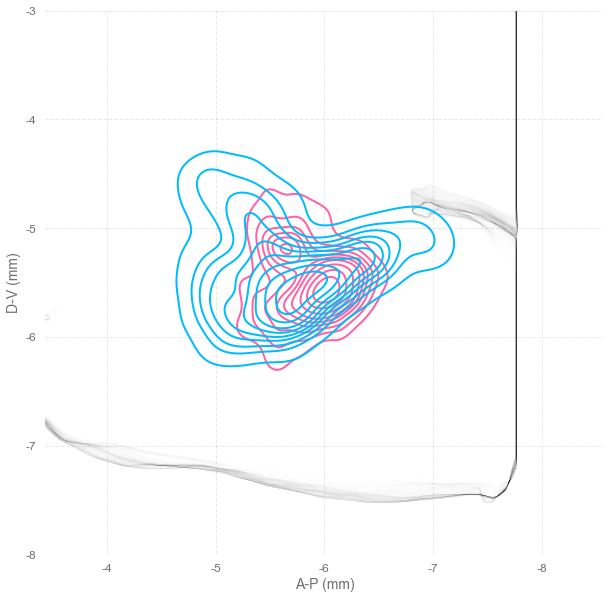

In [254]:
# Density plot sagittal - single. 
i = 0 # change this to plot a desired group of cells. Note "0" is the first one.

# Plot Brain outline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sagittal_merge, cmap="binary", zorder=0)
plt.axis("equal")
ax.set_xlim(940, 1340) # -4mm to -8mm
ax.set_ylim(800, 300) # -3mm to -8mm

# Plot neurons
cc = ["#FF62A4", "#00BCFD", "#D3C93A"]
i_range = range(0, 2)  # set the desired range of i values
j_range = range(len(i_range))  # set the desired range of j values based on the length of i_range
for i, j in zip(i_range, j_range):
    ax = sns.kdeplot(x=file_name[i].AP_location, y=file_name[i].DV_location,
                 color=c[j], zorder=1)

# Convert x and y ticks from Allen CCF to Paxinos. 
ax.set_xticks([940, 1040, 1140, 1240, 1340])
ax.set_xticklabels(['-4', '-5', '-6', '-7', '-8'])

ax.set_yticks([300, 400, 500, 600, 700, 800])
ax.set_yticklabels(['-3', '-4', '-5', '-6', '-7', '-8'])

# x and y labels
plt.xlabel('A-P (mm)')
plt.ylabel('D-V (mm)')

# change the file name when you save 
group = "Sagittal_Density_"
sample = "IRt"
ext = ".pdf"
save_name = group + sample + ext
plt.savefig(save_name, dpi=1200, format="pdf")